# Portland Case Study

In 2024, Portland, OR voters approved a major shift to their electoral system for city council. INSERT BOILERPLATE HERE. There are four districts each electing three councillors via STV. We will focus here on district 1.

## Cleaning the data

The city of Portland released the cast vote record (CVR) for the election in an interesting format. Each voter was given a row in a table, and each column was XXXXXXXXXXX.
In order to make this format readable by VoteKit, we need to transform it so that each column represents one position of a ranking. 

If you want to skip all of the cleaning steps below, you can download the prepared data here. Save the csv file in the same working directory as your Python notebook.

Next, we need to handle ties in positions and undervotes (where a position was skipped.)

Finally, we have a CVR that is cleaned and ready to be analyzed. 

The first thing we should do is verify that our data and outcome matches that of the offical election.
Note that in our data, the rankings are stored in the second through seventh column, so we need to tell the `load_csv` function where to look for them. Python indexing starts from 0.

In [1]:
from votekit.cvr_loaders import load_csv

profile = load_csv("Portland_D1_Condensed.csv", rank_cols = [1,2,3,4,5,6])
print(profile.candidates)

('Michael (Mike) Sands', 'Terrence Hayes', 'Peggy Sue Owens', 'Steph Routh', 'David Linn', 'Doug Clove', 'Loretta Smith', 'Jamie Dunphy', 'Deian Salazar', 'Joe Allen', 'Cayle Tern', 'Noah Ernst', 'Candace Avalos', 'Timur Ender', 'skipped', 'Joe Furi', 'Thomas Shervey', 'Uncertified Write In')


So even though we cleaned it, we retained "skipped" to denote an overvote. Let's remove that.

In [2]:
from votekit.utils import remove_cand
profile = remove_cand("skipped", profile)
print(profile.candidates)

('Michael (Mike) Sands', 'Terrence Hayes', 'Peggy Sue Owens', 'Steph Routh', 'David Linn', 'Doug Clove', 'Loretta Smith', 'Jamie Dunphy', 'Deian Salazar', 'Joe Allen', 'Cayle Tern', 'Noah Ernst', 'Candace Avalos', 'Timur Ender', 'Joe Furi', 'Thomas Shervey', 'Uncertified Write In')


Do we get the same STV winner set? In district 1, Avalos, Dunphy, and Smith were elected. The first place vote distribution was https://www.portland.gov/sites/default/files/2024/Portland-District-1-Certified-Abstract-Nov-2024.pdf.

In [3]:
from votekit.elections import STV
from votekit.utils import first_place_votes

# 3 seat election
election = STV(profile, m=3)
print("Winners in order of election ", election.get_elected(), "\n")

# threshold
print("Threshold: ", election.threshold, "\n")

fpv_dict = first_place_votes(profile)
cands_sorted_by_fpv = sorted(zip(fpv_dict.keys(), fpv_dict.values()), # creates a list of tuples, (name, fpv)
                                reverse=True,  #decreasing order
                                key = lambda x: x[1], # sort by second element of tuple, which is fpv)
                                    )

print("Candidates in decreasing order of first place votes.\n")
for cand, fpv in cands_sorted_by_fpv:
    print(cand, fpv)

Winners in order of election  (frozenset({'Candace Avalos'}), frozenset({'Loretta Smith'}), frozenset({'Jamie Dunphy'})) 

Threshold:  10718 

Candidates in decreasing order of first place votes.

Candace Avalos 8297
Loretta Smith 5586
Jamie Dunphy 5064
Noah Ernst 4052
Terrence Hayes 3975
Steph Routh 3894
Timur Ender 3550
Doug Clove 1698
Peggy Sue Owens 1266
David Linn 1111
Joe Allen 978
Michael (Mike) Sands 952
Deian Salazar 720
Cayle Tern 711
Thomas Shervey 385
Joe Furi 355
Uncertified Write In 277


## Candidate Statistics

Portland had a LOT of candidates. District XXXXX

We choose to categorize the candidates as viable and non-viable. A viable candidate is one that received at least as many mentions as the STV threshold. We call them viable because this is a necessary condition to win. 

(Well, technically it is possible for a non-viable candidate to win by being the last person standing after eliminations, but it is an edge case and does not occur in Portland. Only viable candidates win across all four districts.)

First, let's plot their mentions, along with the threshold for election.

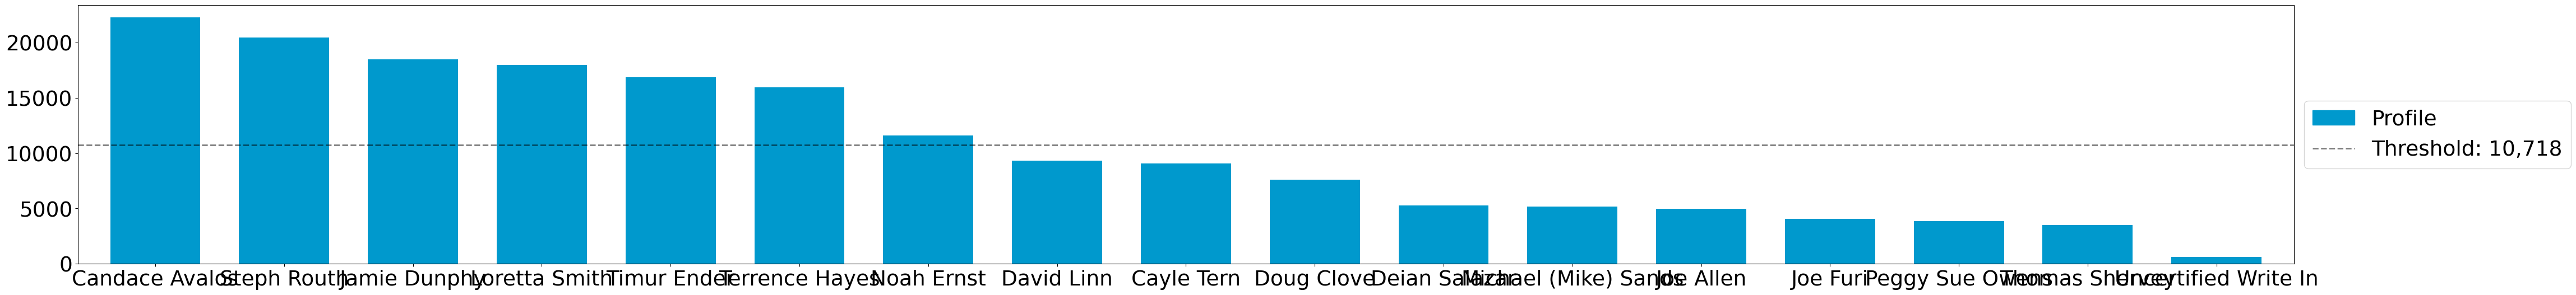

In [4]:
from votekit.plots import profile_mentions_plot

ax = profile_mentions_plot(profile, 
                            threshold_values=election.threshold, 
                            threshold_kwds={"label": f"Threshold: {election.threshold:,}", 
                                        "color":"black", 
                                        "linestyle": "--"},
                            show_profile_legend=True)

Well the candidate names are too long to fit on the axis, so let's relabel them.

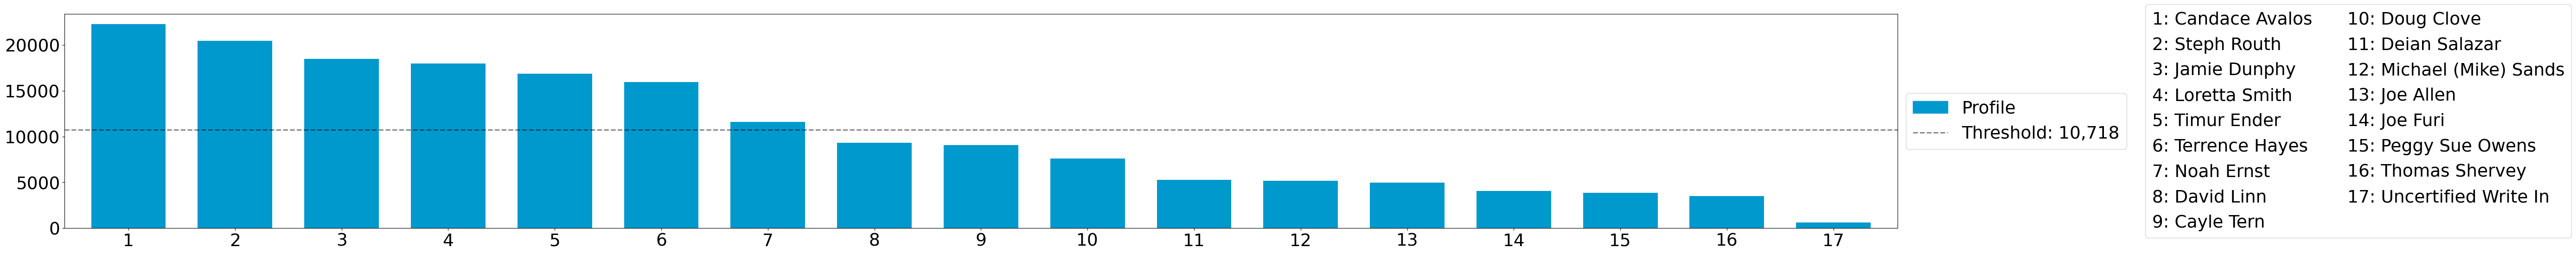

In [5]:
ax = profile_mentions_plot(profile, 
                            threshold_values=election.threshold, 
                            threshold_kwds={"label": f"Threshold: {election.threshold:,}", 
                                        "color":"black", 
                                        "linestyle": "--"},
                            show_profile_legend=True,
                            relabel_candidates_with_int=True)

We now see visually who is viable: Avalos, Routh, Dunphy, Smith, Ender, Hayes, and Ernst.
Oddly enough, Routh, despite having the second most mentions, does not appear in the winner set. We will return to this several times, with various explanations for why that is the case. 

To determine this Pythonically, you can do the following.

In [10]:
from votekit.utils import mentions

mentions_dict = mentions(profile)
viable_cands = [c for c, mentions in mentions_dict.items() if mentions >= election.threshold]

viable_cands = sorted(viable_cands, reverse=True, key = lambda x: mentions_dict[x])
print(viable_cands)

['Candace Avalos', 'Steph Routh', 'Jamie Dunphy', 'Loretta Smith', 'Timur Ender', 'Terrence Hayes', 'Noah Ernst']


Let's also plot their first place votes, next to their mentions. After all, STV is based on first place votes, and this can help explain the winner set we observe. To make a plot this customized, we have to do a bit more work and expose the underlying function that the above is a wrapper for.

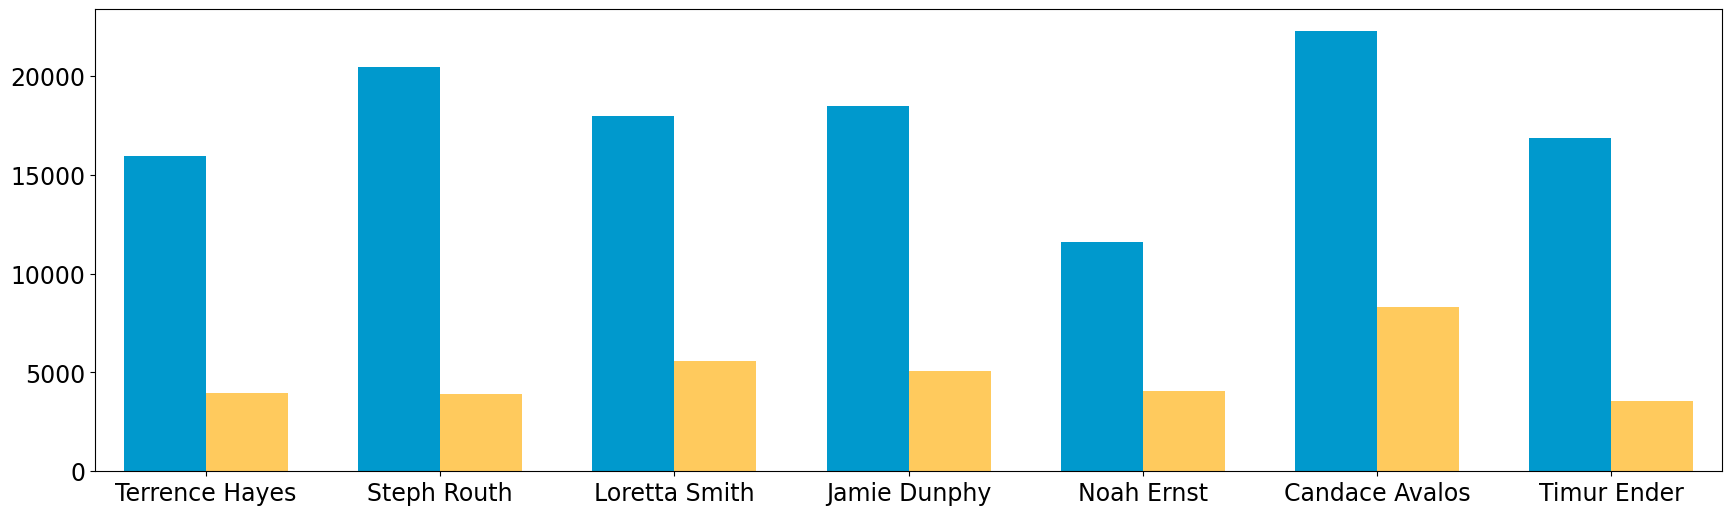

In [11]:
from votekit.plots import multi_bar_plot

viable_cands_mentions = {cand:mentions for cand, mentions in mentions_dict.items() if cand in viable_cands}
viable_cands_fpv = {cand: fpv for cand, fpv in first_place_votes(profile).items() if cand in viable_cands}

ax = multi_bar_plot({"Mentions": viable_cands_mentions, "FPV": viable_cands_fpv})

Whoops, the candidates are not in our desired order. This is also easy to fix.

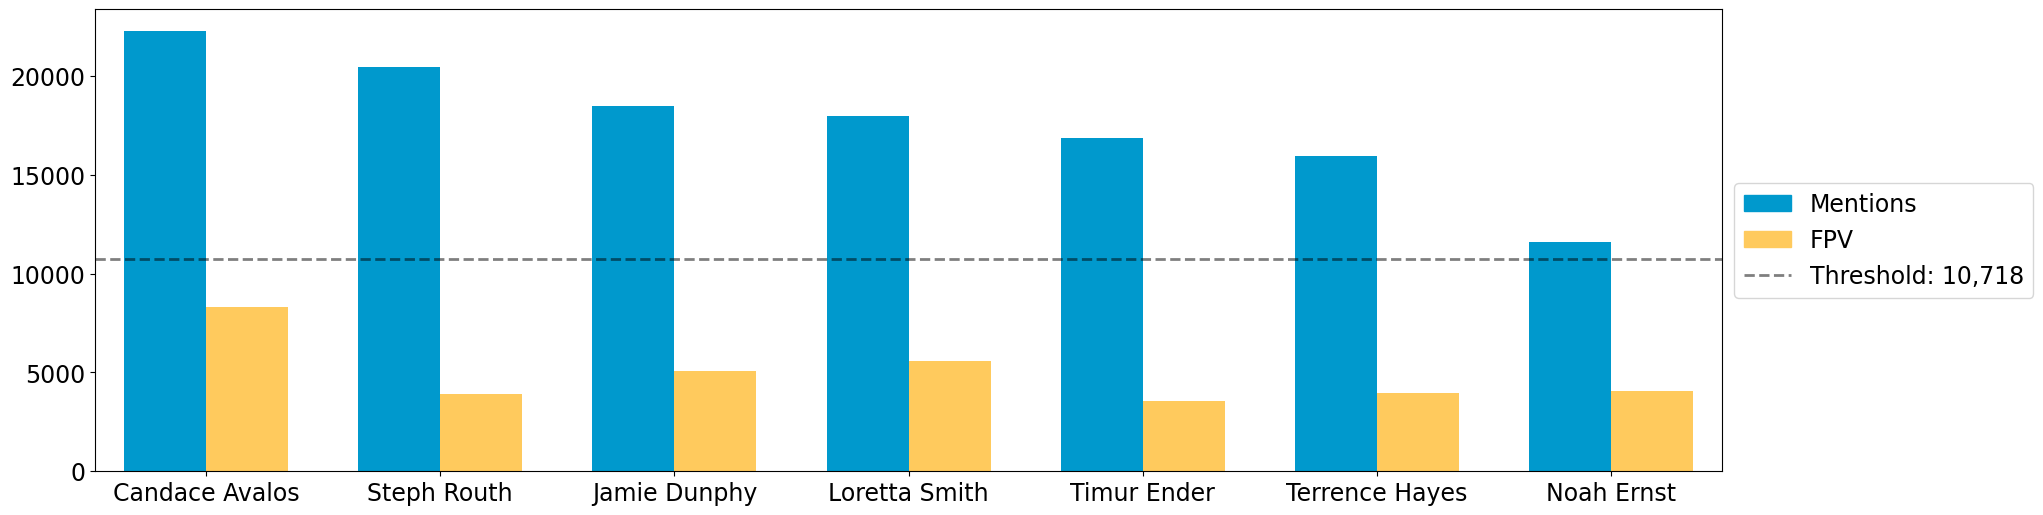

In [12]:
ax = multi_bar_plot({"Mentions": viable_cands_mentions, "FPV": viable_cands_fpv},
                    category_ordering = viable_cands,
                    threshold_values=election.threshold, 
                    threshold_kwds={"label": f"Threshold: {election.threshold:,}", 
                                        "color":"black", 
                                        "linestyle": "--"},
)

We see that part of the reason Routh was not elected is that he has significantly less FPV support than Dunphy and Smith, who were elected.

Finally, we can plot a collection of matrices. The three kinds of matrices are: boost, average distance, and comentions. 

The (i,j) entry of the boost matrix shows P(mention i | mention j) - P(mention i). Thus, the i,j entry shows the boost given to i by j.

In [17]:
from votekit.matrices import matrix_heatmap, boost_matrix, candidate_distance_matrix, comentions_matrix

bm  = boost_matrix(profile, candidates = viable_cands)

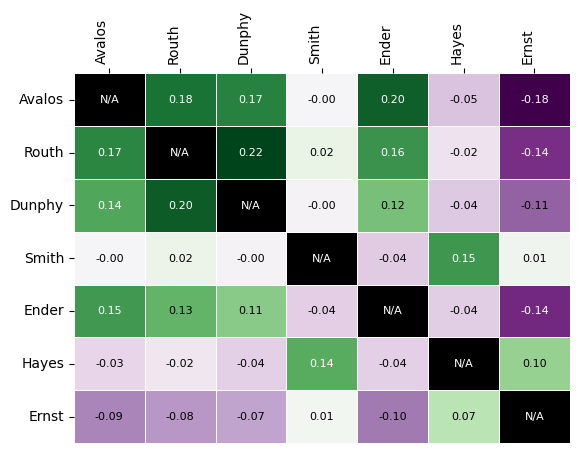

In [19]:
last_names_viable = [c.split(" ")[-1] for c in viable_cands]
ax  = matrix_heatmap(bm, row_labels=last_names_viable, 
                        column_labels=last_names_viable,
                        row_label_rotation = 0,
                        column_label_rotation = 90)

Discussion

The (i,j) entry of the average distance matrix shows, over ballots on which candidates i and j were mentioned, how far apart their rankings were on average.

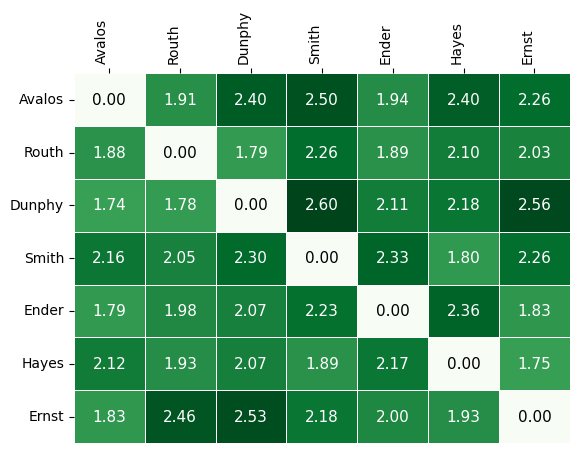

In [20]:
cdm  = candidate_distance_matrix(profile, candidates = viable_cands)
ax  = matrix_heatmap(cdm, row_labels=last_names_viable, 
                        column_labels=last_names_viable,
                        row_label_rotation = 0,
                        column_label_rotation = 90)

Discussion

Finally, the (i,j) entry of the comentions matrix shows the number of times candidates i,j were mentioned on the same ballot with i >= j. There is an option to symmetrize the marrix, which makes the (i,j) entry the number of times that i and j were mentioned on the same ballot (irrespective of position).

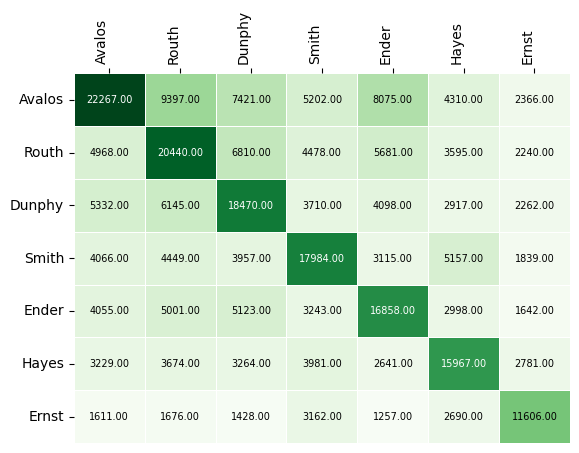

In [22]:
cmm_asym  = comentions_matrix(profile, candidates = viable_cands)
ax  = matrix_heatmap(cmm_asym, row_labels=last_names_viable, 
                        column_labels=last_names_viable,
                        row_label_rotation = 0,
                        column_label_rotation = 90)

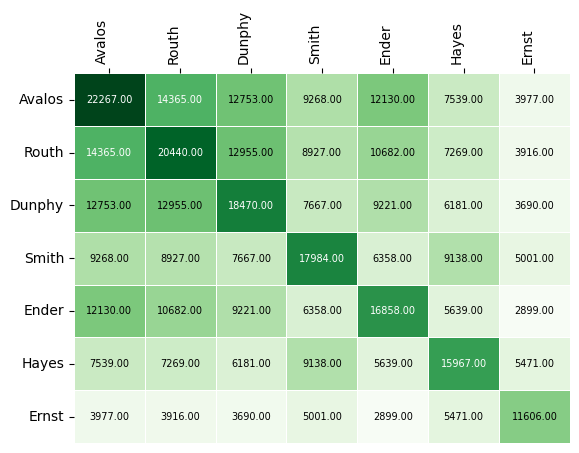

In [23]:
cmm_sym  = comentions_matrix(profile, candidates = viable_cands, symmetric=True)
ax  = matrix_heatmap(cmm_sym, row_labels=last_names_viable, 
                        column_labels=last_names_viable,
                        row_label_rotation = 0,
                        column_label_rotation = 90)

## Profile Statistics

- ballot length
- read more of the portland report